# Measuring Engagement and Satisfaction in Online Mental Health Platform Conversations

## Data preprocessing

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import log10, floor
import math
import nltk
import string
from nltk.tokenize import sent_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.matcher import PhraseMatcher
import joblib
import sklearn.externals
import joblib
from profanity_check import predict, predict_prob

In [262]:
# profanity-check is deprecated and does not work with the latest version of sklearn
# but someone else continues the project under the library alt-profanity-check
# https://gitlab.com/dimitrios/alt-profanity-check
# !pip install alt-profanity-check

In [257]:
sid = SentimentIntensityAnalyzer()

nlp = spacy.load('en_core_web_sm')
phrase_matcher = PhraseMatcher(nlp.vocab)

pd.set_option('mode.chained_assignment',None)

# Display long column text
pd.options.display.max_colwidth = 500

In [73]:
df = pd.read_csv("mentalhealthsupport_dyadic_convs_clean_emotion.csv")
df = df.rename(columns={'conversation id': 'conversation_id', 'post title': 'post_title', 'dialog turn': 'dialog_turn', 'emotion prediction': 'emotion_prediction'})

In [74]:
### --- CLEANING OUT CONVERSATIONS WITH ONLY 1 OR 2 TURN(S) AND/OR WITH A SINGLE AUTHOR --- ###

# Group data by conversation id and calculate count of each conversation id
df_conv_len = df.groupby("conversation_id").count()
df_conv_len = df_conv_len.drop(columns=["subreddit", "post_title", "author", "text", "compound", "sentiment", "emotion_prediction"])
print("Number of conversations in subreddit: ", len(df_conv_len))

# Separate conversation id's with a single occurrence as monologues
df_mono = df_conv_len[df_conv_len["dialog_turn"] == 1]
#print("Number of conversations with a single turn in subreddit: ", len(df_mono))
df_mono_ids = df_mono.reset_index()
df_mono_ids = df_mono_ids["conversation_id"]

# Separate conversation id's with multiple occurrences as dialogues
df_dia = df_conv_len[df_conv_len["dialog_turn"] > 2]
print("Number of conversations longer than 2 turns in subreddit: ", len(df_dia))
df_dia = df_dia.reset_index()
df_dia = df_dia.drop(columns=['dialog_turn'])

# Join dialogue conversation id's with original data such that only dialogues remain in the dataset
df = df.join(df_dia.set_index('conversation_id'), on='conversation_id', how="right") 

# Separate conversations that have more than one author
df_conv_authors = df.groupby("conversation_id")["author"].unique().reset_index()
df_conv_authors["author"] = df_conv_authors["author"].apply(lambda x: x.size)
df_conv_authors = df_conv_authors[df_conv_authors["author"] > 1]
df_conv_authors = df_conv_authors.drop(columns=['author'])

# Join dialogue conversation id's with original data such that only conversations that have more than one author remain in the dataset
df = df.join(df_conv_authors.set_index('conversation_id'), on='conversation_id', how="right") 
print("Number of conversations longer than 2 turns with more than a single author in subreddit: ", len(df_conv_authors))

### ---------------------------------------------- ###

Number of conversations in subreddit:  3551
Number of conversations longer than 2 turns in subreddit:  487
Number of conversations longer than 2 turns with more than a single author in subreddit:  476


In [75]:
# Round numbers to a given number of significant figures (default = 2)
def round_sig(x, sig=2):
    if x != 0:
        return round(x, sig-int(floor(log10(abs(x))))-1)
    else:
        return

## Extracting conversation, speaker, and listener

In [76]:
def extract_responses(conversation_id):
    conversation = df[df["conversation_id"] == conversation_id]
    conversation.reset_index(drop=True, inplace=True)
    speaker = conversation.author.iloc[0]
    listener = conversation[conversation["author"] != speaker]["author"].unique().item() 
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
    # TOIMPROVE: you can only keep conversation, speaker, and listener (because others are dynamic and can be calculated from these 3)
    return conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses

## Measuring the level of engagement

In [77]:
# Calculates token length for all speaker responses except for the first and adds it to a new column 'token_length', and returns their sum.
def calculate_speaker_token_length(conversation, speaker):
    # Create an empty dataframe column 'token_length'
    conversation.loc[:,'token_length'] = np.nan
    
    sum_token_length = 0
    
    for i in range(1, len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            # Tokenize speaker response and filter punctuations
            tokens = nltk.word_tokenize(conversation["text"][i])
            tokens = list(filter(lambda tokens: tokens not in string.punctuation, tokens)) # TOIMPROVE: exclude quotation marks
            
            # Add token length to dataframe
            conversation.at[i,'token_length'] = len(tokens)
            
            # Calculate sum of all tokens by speaker
            sum_token_length += len(tokens)
        
    return conversation, sum_token_length

In [78]:
def merge_consecutive_speaker_responses(conversation, speaker, listener):
    i = 0
    
    while i < (len(conversation) - 1):
        if conversation['author'].iloc[i] == speaker and conversation['author'].iloc[i+1] == speaker:
            if (conversation['dialog_turn'].iloc[i] + 1) == conversation['dialog_turn'].iloc[i+1]:
                dropped_turn = conversation['dialog_turn'].iloc[i+1]
                former_text = conversation['text'][i]
                latter_text = conversation['text'][i+1]

                # Merge consecutive responses of the speaker
                merged_text = former_text + " " + latter_text 
                conversation['text'].replace({former_text: merged_text}, inplace=True)

                # Get names of indexes for which column dialog_turn has value of the dropped turn
                conversation_index_names = conversation[conversation['dialog_turn'] == dropped_turn].index

                # Delete these row indexes from dataframe
                conversation.drop(conversation_index_names, inplace=True)

                # Reset indexes
                conversation.reset_index(drop=True, inplace=True)
                
        i += 1
        
    speaker_responses = conversation[conversation["author"] == speaker]
    listener_responses = conversation[conversation["author"] == listener]
    num_speaker_responses = len(speaker_responses) 
    num_listener_responses = len(listener_responses)
                 
    return conversation, num_speaker_responses, num_listener_responses

In [79]:
# Checks if conversation is interleaved. 
# If all the even-numbered turns are by the speaker and if all the odd-numbered turns are by the listener, returns True. Otherwise, returns False.
def is_interleaved_conversation(speaker, listener, conversation):
    num_turns = len(conversation)
    
    for i in range(0, num_turns, 2):
        if conversation['author'].iloc[i] == speaker:
            continue
        else:
            return False
        
    for i in range(1, num_turns, 2):
        if conversation['author'].iloc[i] == listener:
            continue
        else:
            return False
        
    return True

In [80]:
def calculate_engagement_score(num_turns, interleaved, sum_token_length, diff):
    num_turns_weight = 1
    interleaved_weight = 1
    token_length_weight = 0.05
    diff_weight = -1

    # Set an upper limit to token length's effect on engagement
    if sum_token_length >= 30:
        token_length_score = 30
    else:
        token_length_score = sum_token_length
    
    # Convert boolean to int
    if interleaved == True:
        interleaved_int = 1
    else:
        interleaved_int = -1
    
    return num_turns_weight*num_turns + interleaved_weight*interleaved + token_length_weight*token_length_score + diff_weight*diff

In [81]:
def calculate_engagement(speaker, listener, conversation):
    conversation, num_speaker_responses, num_listener_responses = merge_consecutive_speaker_responses(conversation, speaker, listener)
    conversation, sum_token_length = calculate_speaker_token_length(conversation, speaker)
    diff = num_speaker_responses - num_listener_responses
    diff = abs(diff)
    interleaved = is_interleaved_conversation(speaker, listener, conversation)
    num_turns = len(conversation)
    engagement = ""
    threshold = 4
    
    engagement_score = calculate_engagement_score(num_turns, interleaved, sum_token_length, diff)
    
    if engagement_score > threshold:
        engagement = "highly engaging"
    else:
        engagement = "less engaging"
                    
    return num_turns, interleaved, sum_token_length, round_sig(diff), round_sig(engagement_score), engagement, conversation

## Measuring the level of satisfaction

In [82]:
def plot_emotion_sentiment(conversation, speaker):   
    speaker_responses = conversation[conversation["author"] == speaker]
    sns.set_theme(style="white")
    g = sns.relplot(x="dialog_turn", y="strongest_compound", hue="sentiment", style="emotion_prediction", palette="Set1",data=speaker_responses, s=200)
    g.fig.suptitle('Sentimental and Emotional Shift in Speaker Responses with Conversation Progression', fontsize=16)
    g.fig.subplots_adjust(top=0.9);
    plt.show()

In [83]:
# Return all emotions and the final emotion of the given responses
def get_emotion_prediction(speaker_responses):
    emotions = speaker_responses["emotion_prediction"]
    final_emotion = emotions.iloc[-1]
    
    return emotions, final_emotion

In [84]:
# Return all sentiments and the final sentiment of the given responses
def get_sentiment(speaker_responses):
    sentiments = speaker_responses["sentiment"]
    final_sentiment = sentiments.iloc[-1]
    
    return sentiments, final_sentiment

In [85]:
# Check if the last speaker emotion is grateful and its sentiment is positive. If yes, return true. Otherwise, return false.
def is_tagged_grateful_positive(speaker_responses):
    _, final_sentiment = get_sentiment(speaker_responses)
    _, final_emotion = get_emotion_prediction(speaker_responses)
    
    if final_sentiment == "positive" and final_emotion == "grateful":
        return True
    
    return False

In [ ]:
# Checks if any of the speaker responses, except the first, contain profanity
def contains_profanity(conversation, speaker):
    for i in range(1,len(conversation)):
        if conversation['author'].iloc[i] == speaker:
            if predict([conversation['text'].iloc[i]]) == 1:
                return True
    return False

In [261]:
def contains_grateful_tokens(conversation, speaker):
 
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
   
    phrases = ['thank', 'means a lot to me', 'thanks', 'appreciate', 'your support', 'your help']

    patterns = [nlp(text) for text in phrases]

    phrase_matcher.add('gratitude', None, *patterns)

    sentence = nlp (speaker_responses)

    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [138]:
# Checks if any of the speaker responses, except the first, contain irony
def contains_ironical_tokens(conversation, speaker):
    
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
   
    phrases = ['hate', 'means a lot to me', 'thanks', 'appreciate', 'your support', 'your help']

    patterns = [nlp(text) for text in phrases]

    phrase_matcher.add('gratitude', None, *patterns)

    sentence = nlp (speaker_responses)

    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [178]:
# Checks if any of the speaker responses, except the first, contain disagreement
def contains_disagreement_tokens(conversation, speaker):
        
    # Take the speaker responses except first one
    speaker_responses = conversation[conversation['author'] == speaker]
    speaker_responses = speaker_responses[speaker_responses['dialog_turn'] != 1]
    speaker_responses = speaker_responses['text']
    speaker_responses = speaker_responses.to_string()[1:].lower()
   
    phrases = ['hate', 'means a lot to me', 'thanks', 'appreciate', 'your support', 'your help']

    patterns = [nlp(text) for text in phrases]

    phrase_matcher.add('gratitude', None, *patterns)

    sentence = nlp (speaker_responses)

    matched_phrases = phrase_matcher(sentence)
    
    # uncomment this part if you want to print the matched phrases
    #for match_id, start, end in matched_phrases:
        #string_id = nlp.vocab.strings[match_id]  
        #span = sentence[start:end]                   
        #print(match_id, string_id, start, end, span.text)
    
    if len(matched_phrases) > 0:
        return True
    
    return False

In [94]:
# Creates a column with sentence-level sentiment compounds
def sent_lvl_sentiment(conversation):
    conversation['sentences'] = conversation['text'].apply(lambda x: sent_tokenize(x)) 
    conversation['sentence_compounds'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # sentiment compound for each sentence
        scores = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            scores[j] = sid.polarity_scores(sent_tokenize(conversation['text'][i])[j])['compound']

            conversation['sentence_compounds'][i] = scores
            
    return conversation

In [95]:
# Creates a column with the sentence compound with strongest magnitude within a dialogue turn
def strongest_sentiment(conversation):
    conversation['strongest_compound'] = conversation['sentence_compounds']
    conversation['strongest_compound'] = conversation['strongest_compound'].apply(lambda x: np.min(x) if np.max(abs(x)) == abs(np.min(x)) else np.max(x))
    
    return conversation

In [96]:
# TODO IN LATER WEEKS?
def emobert_predict_sentence_emotion(conversation):
    conversation['sent_emotion_prediction'] = conversation['sentences']
    
    for i in range(0,len(conversation)):
        num_sentences = len(sent_tokenize(conversation['text'].iloc[i]))
        # emotion for each sentence
        emotions = np.zeros(num_sentences) 
        for j in range(0,num_sentences):
            # i'th dialogue turn, j'th sentence
            emotions[j] = sent_tokenize(conversation['text'][i])[j].swifter.apply(emobert_predict_emotion)
            conversation['sent_emotion_prediction'][i] = emotions
            
    return conversation

In [97]:
def calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, offended_penalty):
    slope_weight = 1
    sentiment_change_weight = 1
    grateful_bonus_weight = 1
    offended_penalty_weight = 1
    
    return slope_weight*slope + sentiment_change_weight*sentiment_change + grateful_bonus_weight*grateful_bonus + offended_penalty_weight*offended_penalty

In [170]:
def calculate_satisfaction(conversation, speaker):
    conversation = sent_lvl_sentiment(conversation)
    conversation = strongest_sentiment(conversation)
    speaker_responses = conversation[conversation["author"] == speaker]
    num_speaker_responses = len(speaker_responses)
    
    satisfaction = ""
    grateful_bonus = 0
    profanity_penalty = 0
    threshold = 2
    
    # Change in sentiment from the first to the last turn
    sentiment_change = speaker_responses['strongest_compound'].iloc[-1] - speaker_responses['strongest_compound'].iloc[0]
    
    # Take the slope of the compounds of speaker responses
    f = np.polyfit(speaker_responses['dialog_turn'], speaker_responses['compound'], deg=1)
    slope = f[0]

    if is_tagged_grateful_positive(speaker_responses)==True or contains_grateful_tokens(speaker_responses, speaker)==True:
        grateful_bonus = 1
        
    if contains_profanity(conversation, speaker) == True:
        profanity_penalty = -1
              
    satisfaction_score = calculate_satisfaction_score(slope, sentiment_change, grateful_bonus, profanity_penalty)
                                         
    if satisfaction_score > threshold:
        satisfaction = "highly satisfying"
    else:
        satisfaction = "less satisfying"
        
    return round_sig(slope), sentiment_change, grateful_bonus, profanity_penalty, round_sig(satisfaction_score), satisfaction

## Testing the measures

In [175]:
def test_examples(conversation_id):
    conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(conversation_id)
    turns, interleaved, num_speak_tok, diff, eng_score, eng, conversation = calculate_engagement(speaker, listener, conversation)
    slope, change, grateful, profanity, sat_score, sat = calculate_satisfaction(conversation, speaker)
    
    plot_emotion_sentiment(conversation, speaker)
    
    print("Number of turns: ", turns, ", interleaved: ", interleaved, ", number of speaker tokens: ",  num_speak_tok, 
          ", speaker-listener turn diff: ",  diff, ", ENGAGEMENT SCORE: ",  eng_score, ", ENGAGEMENT: ",  eng)
    
    print("Sentiment slope: ", slope, ", sentiment change: ", change, ", grateful bonus: ", grateful, 
          ", profanity penalty: ", profanity, ", SATISFACTION SCORE: ", sat_score, ", SATISFACTION : ", sat) 
    
    print("Classification summary: ", eng, ", ", sat)
    
    return conversation

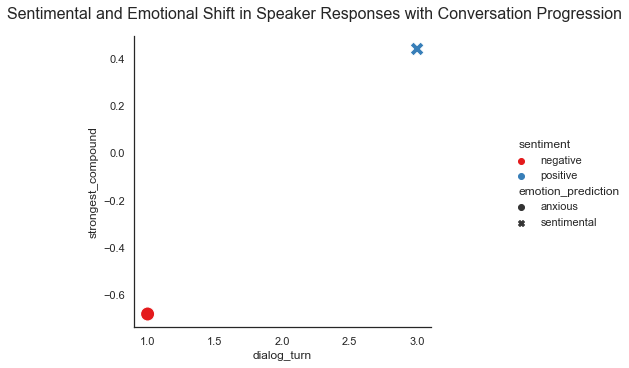

Number of turns:  3 , interleaved:  True , number of speaker tokens:  43 , speaker-listener turn diff:  1 , ENGAGEMENT SCORE:  4.5 , ENGAGEMENT:  highly engaging
Sentiment slope:  0.63 , sentiment change:  1.1212 , grateful bonus:  1 , profanity penalty:  0 , SATISFACTION SCORE:  2.8 , SATISFACTION :  highly satisfying
Classification summary:  highly engaging ,  highly satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,1,"How they knew ill never know... But SOMEONE told them that shouldnt have... Here goes... I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things. . and the cashier says, "" we pay for that, dont we?"" in relation to my purchase. How in the hell did a cashier know i was on disability? Giving me a reason, without an identifiable motive is a good way to get yourself hurt. Keep it up.",-0.8225,negative,anxious,NaN,"[How they knew ill never know..., But SOMEONE told them that shouldnt have..., Here goes..., I was on my way home after an evaluation ( dont worry everyone, still nutty) and i stop by the grocery store to pick up a few things., ., and the cashier says, "" we pay for that, dont we?"", in relation to my purchase., How in the hell did a cashier know i was on disability?, Giving me a reason, without an identifiable motive is a good way to get yourself hurt., Keep it up.]","[-0.4215, 0.0, 0.0, 0.0531, 0.0, -0.1027, 0.0, -0.6808, 0.2263, 0.0]",-0.6808
1,24,MentalHealthSupport,Threatened by a stranger about mental disability.,shatterSquish,2,"That doesn't sound at all like they knew you were on disability. I think you're jumping to conclusions here. For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.",0.3400,positive,anxious,NaN,"[That doesn't sound at all like they knew you were on disability., I think you're jumping to conclusions here., For example, their comment would also make sense in another context: if they just had to deal with a shoplifting kid and had just given a lecture about how everyone needs to pay for the stuff they want.]","[0.3612, 0.0, -0.0258]",0.3612
2,24,MentalHealthSupport,Threatened by a stranger about mental disability.,N08ody,3,"Hey squish. Thanks for not just telling me it was ""all in my head."" A. I wasnt shoplifting. And B. The phrase ""We pay for that, dont we?"" is not a normal phrase. Appreciate your input, but i disagree.",0.4404,positive,sentimental,43.0,"[Hey squish., Thanks for not just telling me it was ""all in my head."", A. I wasnt shoplifting., And B., The phrase ""We pay for that, dont we?"", is not a normal phrase., Appreciate your input, but i disagree.]","[0.0, 0.4404, 0.0, 0.0, -0.1027, 0.0, -0.3716]",0.4404


In [176]:
test_examples(24) 

## More examples

### Profanity

In [201]:
conversation, speaker, listener, speaker_responses, listener_responses, num_speaker_responses, num_listener_responses = extract_responses(702)
conversation['text'].replace({'I will look into it, thank you.': 'I will look into it, hate you.'}, inplace=True)
conversation

,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction
0,702,MentalHealthSupport,Im worried about my mental health,ThrowingpitifulBull,1,"So, i made this account just to ask for help on what i should do as i think i have bad mental health, im also going to leave out a lot of details due to me not wanting to be identified. sorry for my bad grammar and vocabulary its because im not from an english speaking country and im on phone. ( im under 17, im not going to reveal my exact age though) I dont really know how i am supposed to start this thread/post but here we go. I was bullied from before pre-school... a lot, tge worst wa...",-0.9958,negative,joyful
1,702,MentalHealthSupport,Im worried about my mental health,Th3BookSniff3r,2,"Holy cow kid, we need to get you some help! Best way to handle this is going to be up to you in the end. You must choose to get help, the way I started seeking help for myself was calling the crisis line. Most countries have one. Yours might be referred to as a suicide hotline. When I was scared of what getting treatment might mean it was a good way of getting help without being brought immediately to the hospital. (Has happened to me dozens of times in college and is kind of uncomfortable.....",-0.2853,negative,anticipating
2,702,MentalHealthSupport,Im worried about my mental health,ThrowingpitifulBull,3,"I will look into it, hate you.",0.3612,positive,anticipating


In [203]:
contains_profanity(conversation, speaker)

True

### High engagement, neutral satisfaction (but should be positive satisfaction)

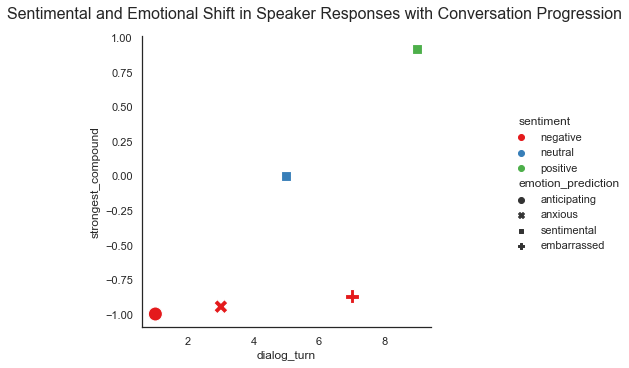

Number of turns:  10 , interleaved:  True , number of speaker tokens:  211 , speaker-listener turn diff:  None , ENGAGEMENT SCORE:  12.0 , ENGAGEMENT:  highly engaging
Sentiment slope:  0.2 , sentiment change:  1.9149 , grateful bonus:  1 , offended penalty:  0 , SATISFACTION SCORE:  3.1 , SATISFACTION :  highly satisfying
Classification summary:  highly engaging ,  highly satisfying


,conversation_id,subreddit,post_title,author,dialog_turn,text,compound,sentiment,emotion_prediction,token_length,sentences,sentence_compounds,strongest_compound
0,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,1,"I’m kinda worried about posting this here because I don’t know if it is correct or not but I’m stuck in a very bad anxiety hole atm, I posted this in one of the legal advice subs and everyone said it’s more of a mental health problem, (also sorry I don’t know how to do paragraphs) ok so recently every single day and night I’ve been having panic attacks over something that happened 2-3 years ago, when I was 13 I was on pornhub and came across Ben 10 hentai and being thirty I was very stupid a...",-0.9960,negative,anticipating,NaN,"[I’m kinda worried about posting this here because I don’t know if it is correct or not but I’m stuck in a very bad anxiety hole atm, I posted this in one of the legal advice subs and everyone said it’s more of a mental health problem, (also sorry I don’t know how to do paragraphs) ok so recently every single day and night I’ve been having panic attacks over something that happened 2-3 years ago, when I was 13 I was on pornhub and came across Ben 10 hentai and being thirty I was very stupid ...",[-0.996],-0.9960
1,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,2,No it's not illegal and you won't get in trouble for it. Especially as pornhub is legal. There's weirder things on there like scooby doo or American dad sketches. We all get curious. There's nothing to worry about x,0.8477,positive,faithful,NaN,"[No it's not illegal and you won't get in trouble for it., Especially as pornhub is legal., There's weirder things on there like scooby doo or American dad sketches., We all get curious., There's nothing to worry about x]","[0.4556, 0.128, 0.25, 0.3182, 0.3412]",0.4556
2,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,3,"Thank you so much, I’ve felt so bad for so long, I was at the point where I can’t handle it anymore, I know this whole thing sounds stupid but I have been having serious suicidal thoughts over it, after reading your comment I’m crying lol, I was so worried about posting this but I’m at the point where it was either a suicidal help line or this, I chose this because I wasn’t brave enough for the latter but seriously thank you I was so nervous, also please excuse my lack of ability to do parag...",-0.9430,negative,anxious,116.0,"[Thank you so much, I’ve felt so bad for so long, I was at the point where I can’t handle it anymore, I know this whole thing sounds stupid but I have been having serious suicidal thoughts over it, after reading your comment I’m crying lol, I was so worried about posting this but I’m at the point where it was either a suicidal help line or this, I chose this because I wasn’t brave enough for the latter but seriously thank you I was so nervous, also please excuse my lack of ability to do para...",[-0.943],-0.9430
3,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,4,No problem. I was the same when I started exploring that side of the web. It's harmless x,0.5037,positive,sentimental,NaN,"[No problem., I was the same when I started exploring that side of the web., It's harmless x]","[0.3089, 0.0, 0.25]",0.3089
4,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,5,So do you really think I’ll be ok?,0.0000,neutral,sentimental,10.0,[So do you really think I’ll be ok?],[0.0],0.0000
5,1732,MentalHealthSupport,"Hello, I need some advice/help",SophieSofar,6,Yeah for sure. Pornhub can't have anything illegal on there or they'll lose their licence,0.5753,positive,angry,NaN,"[Yeah for sure., Pornhub can't have anything illegal on there or they'll lose their licence]","[0.5423, 0.0577]",0.5423
6,1732,MentalHealthSupport,"Hello, I need some advice/help",itsyaboi-apyr,7,"I was just really worried because i read that even hentai which is underage is illegal, 

In [166]:
test_examples(1732) 

### High engagement, moderate satisfaction

In [ ]:
test_examples(1003) 

### High engagement, neutral satisfaction

In [ ]:
test_examples(854) 

### Moderate engagement, neutral satisfaction

In [ ]:
test_examples(24) 

### Low engagement, moderate satisfaction

In [ ]:
test_examples(35) 